In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install folium
import folium 

!pip install h3
import h3
from collections import Counter

  Obtaining dependency information for h3 from https://files.pythonhosted.org/packages/36/25/c352d44f276cad160f5a639d75f2fc4a2495e393a00797a7acd38c6bec81/h3-4.2.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/808.0 kB ? eta -:--:--
    --------------------------------------- 10.2/808.0 kB ? eta -:--:--
    --------------------------------------- 10.2/808.0 kB ? eta -:--:--
    --------------------------------------- 10.2/808.0 kB ? eta -:--:--
    --------------------------------------- 10.2/808.0 kB ? eta -:--:--
   -- ------------------------------------ 61.4/808.0 kB 234.9 kB/s eta 0:00:04
   -- ------------------------------------ 61.4/808.0 kB 234.9 kB/s eta 0:00:04
   -- ------------------------------------ 61.4/808.0 kB 234.9 kB/s eta 0:00:04
   ---- --------------------------------- 102.4/808.0 kB 268.7 kB/s eta 0:00:03
   ------ ------------------------------- 133.1/808.0 kB 302.7 kB/s eta 0:00:03
   ------ ------------------------------- 1

In [4]:
sns.set_style("whitegrid")

In [5]:
data_orders = pd.read_csv(r'C:\Users\heena\Downloads\datasets\datasets\data_orders.csv')
data_offers = pd.read_csv(r'C:\Users\heena\Downloads\datasets\datasets\data_offers.csv')

In [6]:
print("OrdersData Preview:")
print(data_orders.head())

OrdersData Preview:
  order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0       18:08:07         -0.978916        51.456173         60.0   
1       20:57:32         -0.950385        51.456843          NaN   
2       12:07:50         -0.969520        51.455544        477.0   
3       13:50:20         -1.054671        51.460544        658.0   
4       21:24:45         -0.967605        51.458236          NaN   

        order_gk  order_status_key  is_driver_assigned_key  \
0  3000583041974                 4                       1   
1  3000583116437                 4                       0   
2  3000582891479                 4                       1   
3  3000582941169                 4                       1   
4  3000583140877                 9                       0   

   cancellations_time_in_seconds  
0                          198.0  
1                          128.0  
2                           46.0  
3                           62.0  
4                      

In [7]:
print("\nOffers data preview:")
print(data_offers.head())


Offers data preview:
        order_gk      offer_id
0  3000579625629  300050936206
1  3000627306450  300052064651
2  3000632920686  300052408812
3  3000632771725  300052393030
4  3000583467642  300051001196


In [8]:
print("\nMissing values in orders dataset:")
print(data_orders.isnull().sum())


Missing values in orders dataset:
order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64


In [10]:
data_orders["order_datetime"] = pd.to_datetime(data_orders['order_datetime'])
data_orders["hour"] = data_orders["order_datetime"].dt.hour

In [11]:
failure_reasons = {
    4: "Cancelled by Client",
    9: "Cancelled by System"
}
data_orders["failure_reason"] = data_orders["order_status_key"].map(failure_reasons)

In [12]:
data = data_orders.merge(data_offers, on="order_gk", how="left")

In [13]:
print("\nMerged data preview:")
print(data.head())


Merged data preview:
       order_datetime  origin_longitude  origin_latitude  m_order_eta  \
0 2025-02-05 18:08:07         -0.978916        51.456173         60.0   
1 2025-02-05 20:57:32         -0.950385        51.456843          NaN   
2 2025-02-05 20:57:32         -0.950385        51.456843          NaN   
3 2025-02-05 20:57:32         -0.950385        51.456843          NaN   
4 2025-02-05 12:07:50         -0.969520        51.455544        477.0   

        order_gk  order_status_key  is_driver_assigned_key  \
0  3000583041974                 4                       1   
1  3000583116437                 4                       0   
2  3000583116437                 4                       0   
3  3000583116437                 4                       0   
4  3000582891479                 4                       1   

   cancellations_time_in_seconds  hour       failure_reason      offer_id  
0                          198.0    18  Cancelled by Client  3.000510e+11  
1             

In [14]:
#Visualizations

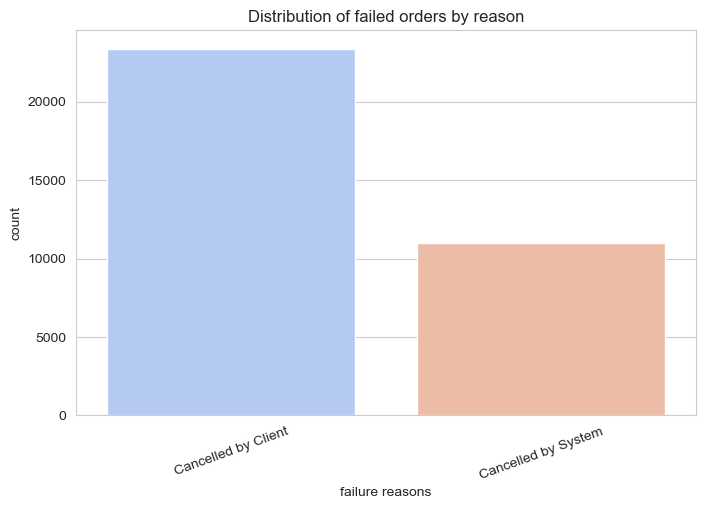

In [15]:
#1. distribution of failed order by reason
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x="failure_reason", palette="coolwarm")
plt.title("Distribution of failed orders by reason")
plt.xlabel("failure reasons")
plt.ylabel("count")
plt.xticks(rotation=20)
plt.show()

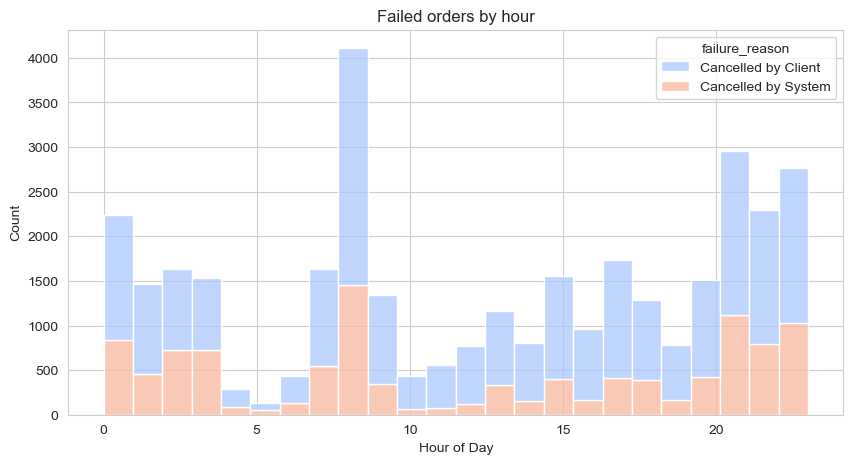

In [16]:
#2. Distribution of failed orders by hour
plt.figure(figsize=(10,5))
sns.histplot(data, x="hour", hue="failure_reason", multiple="stack", bins=24, palette="coolwarm")
plt.title("Failed orders by hour")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()

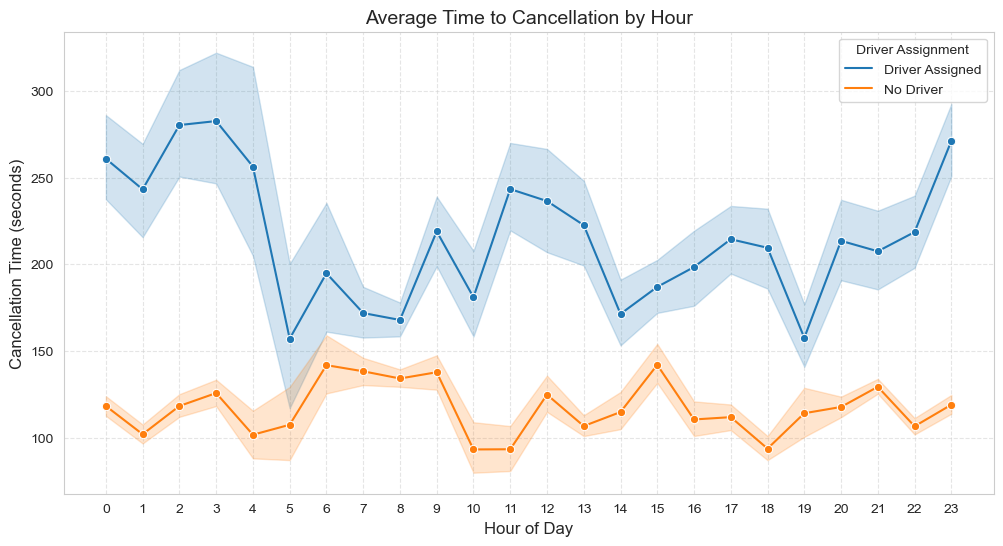

In [35]:
#3. Average time to cancellation analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if "cancellations_time_in_seconds" in data.columns and "is_driver_assigned_key" in data.columns:
    
    if "hour" not in data.columns:
        if "request_timestamp" in data.columns:
            data["request_timestamp"] = pd.to_datetime(data["request_timestamp"])
            data["hour"] = data["request_timestamp"].dt.hour
        else:
            raise ValueError("No 'hour' or 'request_timestamp' column found in the dataset!")

    cancellation_threshold = data["cancellations_time_in_seconds"].quantile(0.99)
    filtered_data = data[data["cancellations_time_in_seconds"] <= cancellation_threshold].copy()

    filtered_data["has_driver"] = filtered_data["is_driver_assigned_key"].map({0: "No Driver", 1: "Driver Assigned"})

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=filtered_data, x="hour", y="cancellations_time_in_seconds", hue="has_driver", marker="o")
    plt.title("Average Time to Cancellation by Hour", fontsize=14)
    plt.xlabel("Hour of Day", fontsize=12)
    plt.ylabel("Cancellation Time (seconds)", fontsize=12)
    plt.xticks(range(24))  
    plt.grid(True, linestyle="--", alpha=0.5) 
    plt.legend(title="Driver Assignment")
    plt.show()

else:
    print("Required columns not found in the dataset!")


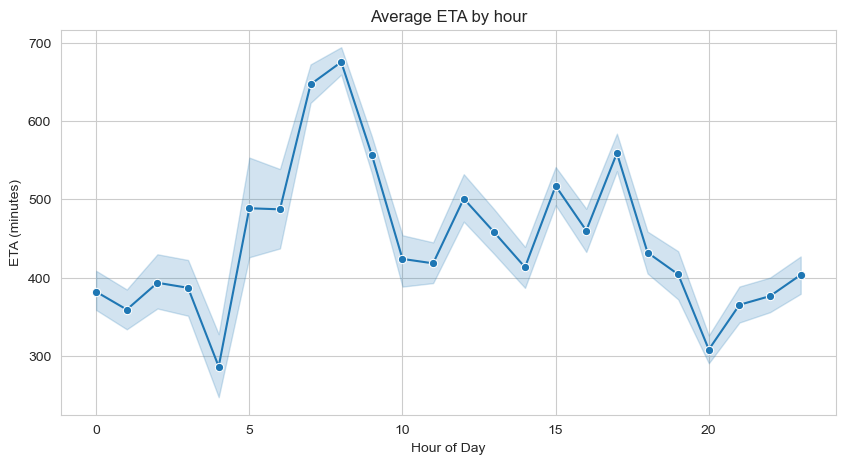

In [23]:
#4. distribution of ETA by hour
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x="hour", y="m_order_eta", marker="o")
plt.title("Average ETA by hour")
plt.xlabel("Hour of Day")
plt.ylabel("ETA (minutes)")
plt.show()

In [33]:
import h3
import folium
import pandas as pd
from collections import Counter
from IPython.display import display  

failed_orders = data.dropna(subset=["origin_latitude", "origin_longitude"])

hex_size = 8 
failed_orders["h3_index"] = failed_orders.apply(
    lambda row: h3.latlng_to_cell(row["origin_latitude"], row["origin_longitude"], hex_size), axis=1
)

hex_counts = Counter(failed_orders["h3_index"])

top_hexes = dict(sorted(hex_counts.items(), key=lambda x: x[1], reverse=True)[:int(len(hex_counts) * 0.8)])

m = folium.Map(location=[failed_orders["origin_latitude"].mean(), failed_orders["origin_longitude"].mean()], zoom_start=12)

for hex_id, count in top_hexes.items():
    poly = h3.cell_to_boundary(hex_id)
    
    folium.Polygon(
        locations=[(lat, lng) for lat, lng in poly], 
        color="red",
        fill=True,
        fill_opacity=0.4,
        popup=f"Fails: {count}"
    ).add_to(m)


display(m)
